In [444]:
import requests
import json
from pprint import pprint
import pandas as pd

def priceToken0(swap):
    """
    Converting from Uniswap's SqrtPriceX96 quantity
    to a de-sqrt'ed, de-X96'ed, and de-decimalized number.
    
    This gives the price of token1 in units of token0.
    
    Reference: https://docs.uniswap.org/sdk/v3/guides/fetching-prices
    """
    d0 = int(swap["pool"]["token0"]["decimals"])
    d1 = int(swap["pool"]["token1"]["decimals"])

    p_smol = float(swap["sqrtPriceX96"])**2 / (2**192)
    
    p = p_smol * (10**(-d1)) / (10**(-d0))
    
    return p

def priceToken1(swap):
    """
    This gives the price of token1 in units of token0.
    """
    return 1/priceToken0(swap)

def prepswapdata(swaps):    
    rows = []
    router_addresses = {
        "0xe592427a0aece92de3edee1f18e0157c05861564", # V3 router
        "0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45", # V3 router 2
        "0x881d40237659c251811cec9c364ef91dc08d300c", # metamask
        "0x1111111254fb6c44bac0bed2854e76f90643097d", # 1inch V4 aggregation router
        "0x1111111254eeb25477b68fb85ed929f73a960582", # 1inch V5 aggregation router
        "0x53222470cdcfb8081c0e3a50fd106f0d69e63f20", # 1inch unlabeled
    }
    for swap in swaps:
        rows.append(
            {
                "amount0": float(swap["amount0"]),
                "amount1": float(swap["amount1"]),
                "boughtToken0": 1 if (float(swap["amount0"]) < 0) else 0, # it's a buy if amount0 is positive
                "viaRouter": 1 if (swap["sender"] in router_addresses) else 0,
                "price0After": priceToken0(swap),
                "price1After": priceToken1(swap),
                "blockNumber": int(swap["transaction"]["blockNumber"]),
                "logIndex": int(swap["logIndex"]),
                "blockTimestamp": float(swap["timestamp"]),
                "txnHash": swap["transaction"]["id"],
                "origin": swap["origin"],
            }
        )
    
    df = pd.DataFrame(rows)
    df = df.sort_values(by=["blockNumber", "logIndex"], ascending=True) # sorts the transactions by occurrence within the block
    return df

def getswaps(pool, cutoff_timestamp=1668227632):
    """
    Get all of the Uniswap swaps on a particular pool, back
    to a specific time `cutoff_timestamp`.
    
    pool: str
    cutoff_timestamp: int
    """
    pool = pool.lower().strip()
    url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    allswaps = []
    sup_timestamp = 10**15 # greates that the timestamp can be, on each round of pagination
    
    for i in range(1_001):
        print("i:", i)
        
        query = '''
        {
            swaps(
                first: 1000, 
                orderBy: timestamp, 
                orderDirection: desc,
                where: {
                    pool: "%s",
                    timestamp_lte: %d
                    #timestamp_gt: %d
                }
            ) {
                amount0
                amount1
                amountUSD
                timestamp
                sqrtPriceX96
                tick
                logIndex
                sender
                origin

                pool {
                    token0 {
                        id
                        symbol
                        decimals
                    }
                    token1 {
                        id
                        symbol
                        decimals
                    }
                    #feesUSD
                    #txCount
                    #observationIndex
                    #collectedFeesUSD
                    #collectedFeesToken0
                    #collectedFeesToken1
                }
                
                transaction {
                    blockNumber,
                    id
                    
                }
            }
        }
        ''' % (
            pool,
            sup_timestamp,
            cutoff_timestamp
        )

        result = json.loads(requests.post(
            url,
            json={"query": query}
        ).content)

        if ("data" not in result) or (len(result["data"]["swaps"]) == 0):
            pprint(result)
            print("breaking a")
            break

        swaps = result["data"]["swaps"]


        # linear-time search for the last timestamp; can be optimized to O(log(n)), but not worth it rn
        j = len(swaps)
        while int(swaps[j-1]["timestamp"]) < cutoff_timestamp:
            j -= 1

        if sup_timestamp == int(swaps[j-1]["timestamp"]):
            # note, this could be problematic if we had >1,000 swaps that all had the same timestamp
            print("done, since we have the same sup_timestamp as before")
            break
        else:
            sup_timestamp = int(swaps[j-1]["timestamp"]) # set the maximum time
            print("sup timestamp", sup_timestamp, "\n")

        # concatenate all swaps that have timestamp >= cutoff_timestamp
        allswaps += swaps[:j]
        if j != len(swaps):
            print("done, since the final swap is in the interior of the result batch")
            break
            
    pprint(allswaps[-1])
            
    return prepswapdata(allswaps)


In [445]:
swaps_ = getswaps("0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", 1671062760)
swaps_

i: 0
sup timestamp 1671138635 

i: 1
sup timestamp 1671126167 

i: 2
sup timestamp 1671115319 

i: 3
sup timestamp 1671105359 

i: 4
sup timestamp 1671092111 

i: 5
sup timestamp 1671081419 

i: 6
sup timestamp 1671069971 

i: 7
sup timestamp 1671062771 

done, since the final swap is in the interior of the result batch
{'amount0': '-22223.877398',
 'amount1': '17',
 'amountUSD': '22244.06178678626004084444294111272',
 'logIndex': '178',
 'origin': '0x69d52023178740a87b7fa05c9b8921791a4dc0ca',
 'pool': {'token0': {'decimals': '6',
                     'id': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
                     'symbol': 'USDC'},
          'token1': {'decimals': '18',
                     'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
                     'symbol': 'WETH'}},
 'sender': '0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45',
 'sqrtPriceX96': '2190742427558338425649492971662828',
 'tick': '204558',
 'timestamp': '1671062771',
 'transaction': {'blockNumber': '16186

,amount0,amount1,boughtToken0,viaRouter,price0After,price1After,blockNumber,logIndex,blockTimestamp,txnHash,origin
7717,-22223.877398,17.000000,1,1,0.000765,1307.905991,16186408,178,1.671063e+09,0x81c10ca555a95c360ba3fbcf168b1fccfb26a932eacc...,0x69d52023178740a87b7fa05c9b8921791a4dc0ca
7716,-172.820489,0.132201,1,1,0.000765,1307.905448,16186409,32,1.671063e+09,0x069715917723d547b9f1234f70b5ed5849656598ed89...,0xe1cf62a31c1561a40472eeef42966a056ba64864
7714,-38174.692721,29.203594,1,0,0.000765,1307.785604,16186409,38,1.671063e+09,0xc96daab972bb5942e978cf0a04112545f4bbb114302c...,0xfb9779477e5b4834bf2bc02dd29b97b344d0f700
7715,-620.395716,0.474624,1,1,0.000765,1307.783656,16186409,57,1.671063e+09,0x182e01d6768f3114f9dd1d3306bb36817a2f765618c9...,0xc07c7a221f9e26f3fd77deb2a5255d7dd1a63ec0
7713,-3809.343023,2.914294,1,1,0.000765,1307.771697,16186411,326,1.671063e+09,0xba2964fc7858c74615972d6fb9948a059a6f7df3b34b...,0x9a25d79ab755718e0b12bd3c927a010a543c2b31
...,...,...,...,...,...,...,...,...,...,...,...
4,1127.742657,-0.890000,0,1,0.000790,1266.494460,16193574,185,1.671149e+09,0xb59e27a6696aa9370058f4b4de33b5b3a85206c456ed...,0xd057299123251e663d352b2f94d6b0fd83f31f5f
3,-2519.080844,1.990019,1,1,0.000790,1266.488006,16193575,13,1.671149e+09,0x2e5d0c992084df9fd63801b7a942fb425c851e41867e...,0x89b537d4e0de035303dc1bdae18394f7a6c15c36
2,-316.463589,0.250000,1,1,0.000790,1266.487195,16193575,38,1.671149e+09,0xf1f9eb71f5c9652391684400801f3f4b742a2a5961bf...,0x3e27d0cee58273fff8053043963d0c49bf5dfee7
1,382.696002,-0.302020,0,1,0.000790,1266.488175,16193575,289,1.671149e+09,0xf23a8788e0ab4e1e1e6664098ba4355bea6f21f8efdc...,0xceb6dd944b16ca8463772b2ef3703a2001f5fda6


In [467]:
# is_informed() filters. 1=informed, 0=uninformed

eps_ = 1e-10
has_lte_5_dec = lambda x: (((x%1) % 1e-5)/(1e-5) < eps_) or (1-((x%1) % 1e-5)/(1e-5) < eps_)

def is_informed1(swaps_in_block, swap_index):
    """
    Checks if either of the swaps have more than 5 decimals of precision.
    The idea is that uninformed flow typically won't use many decimals.
    Otherwise, we assume that it's an informed order.
    """
    swap = swaps_in_block.iloc[swap_index]
    return not (has_lte_5_dec(swap.amount0) or has_lte_5_dec(swap.amount1))
    
def is_informed2(swaps_in_block, swap_index):
    """
    Checks if the next trade is in the opposite direction. If it's in the opposite
    direction, then we assume that this trade is uninformed. If it's in the same
    direction, then we assume that this trade is informed.
    """
    swap = swaps_in_block.iloc[swap_index]
    if swap_index+1 >= len(swaps_in_block):
        return -1
    
    next_swap = swaps_in_block.iloc[swap_index+1]
    
    return (
        ((swap.boughtToken0==1) and (next_swap.boughtToken0==1)) or 
        ((swap.boughtToken0==0) and (next_swap.boughtToken0==0))
    )
    
def is_informed3(swaps_in_block, swap_index):
    """
    Checks if an order went through the Uniswap V3 router.
    """
    swap = swaps_in_block.iloc[swap_index]
    return False if (swap.viaRouter == 1) else True

def is_informed_agg(swaps_in_block, swap_index):
    """
    One could imagine aggregating our three signals
    to see if it's informed orderflow. However, we think
    one of those signals -- whether it used a router --
    is the best signal.
    """
    return is_informed3(swaps_in_block, swap_index)

def informedness(swaps):
    blocknumbers = swaps.blockNumber.unique()
    informedness_vals = {}
    for blocknum in blocknumbers:
        swaps_in_block = swaps[swaps.blockNumber == blocknum]
        for swap_index in range(len(swaps_in_block)):
            informedness_vals[swaps_in_block.index.values[swap_index]] = 1 if is_informed_agg(swaps_in_block, swap_index) else 0
#         break
    return pd.Series(informedness_vals)



In [468]:
swaps_["informed"] = informedness(swaps_)

In [469]:
swaps_

,amount0,amount1,boughtToken0,viaRouter,price0After,price1After,blockNumber,logIndex,blockTimestamp,txnHash,origin,informed
7717,-22223.877398,17.000000,1,1,0.000765,1307.905991,16186408,178,1.671063e+09,0x81c10ca555a95c360ba3fbcf168b1fccfb26a932eacc...,0x69d52023178740a87b7fa05c9b8921791a4dc0ca,0
7716,-172.820489,0.132201,1,1,0.000765,1307.905448,16186409,32,1.671063e+09,0x069715917723d547b9f1234f70b5ed5849656598ed89...,0xe1cf62a31c1561a40472eeef42966a056ba64864,0
7714,-38174.692721,29.203594,1,0,0.000765,1307.785604,16186409,38,1.671063e+09,0xc96daab972bb5942e978cf0a04112545f4bbb114302c...,0xfb9779477e5b4834bf2bc02dd29b97b344d0f700,1
7715,-620.395716,0.474624,1,1,0.000765,1307.783656,16186409,57,1.671063e+09,0x182e01d6768f3114f9dd1d3306bb36817a2f765618c9...,0xc07c7a221f9e26f3fd77deb2a5255d7dd1a63ec0,0
7713,-3809.343023,2.914294,1,1,0.000765,1307.771697,16186411,326,1.671063e+09,0xba2964fc7858c74615972d6fb9948a059a6f7df3b34b...,0x9a25d79ab755718e0b12bd3c927a010a543c2b31,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4,1127.742657,-0.890000,0,1,0.000790,1266.494460,16193574,185,1.671149e+09,0xb59e27a6696aa9370058f4b4de33b5b3a85206c456ed...,0xd057299123251e663d352b2f94d6b0fd83f31f5f,0
3,-2519.080844,1.990019,1,1,0.000790,1266.488006,16193575,13,1.671149e+09,0x2e5d0c992084df9fd63801b7a942fb425c851e41867e...,0x89b537d4e0de035303dc1bdae18394f7a6c15c36,0
2,-316.463589,0.250000,1,1,0.000790,1266.487195,16193575,38,1.671149e+09,0xf1f9eb71f5c9652391684400801f3f4b742a2a5961bf...,0x3e27d0cee58273fff8053043963d0c49bf5dfee7,0
1,382.696002,-0.302020,0,1,0.000790,1266.488175,16193575,289,1.671149e+09,0xf23a8788e0ab4e1e1e6664098ba4355bea6f21f8efdc...,0xceb6dd944b16ca8463772b2ef3703a2001f5fda6,0


In [473]:
proportion_informed = len(swaps_[swaps_.informed == 1]) / len(swaps_); proportion_informed
print(f"Portion of swaps that are informed: {100*proportion_informed:<.2f}%.")
# s_ = list(sorted(informedness(swaps_), key=lambda x: x[0]))
# sum([x[0] for x in s_]) / len(s_) # proportion of informed trades
# # s_;

Portion of swaps that are informed: 19.47%.


In [478]:
volume_informed_ = sum(swaps_[swaps_.informed == 1].amount0.abs()); volume_informed_
volume_total_ = sum(swaps_.amount0.abs()); volume_total_
proortion_volume_informed_ = volume_informed_/volume_total_
print(f"Portion of swap volume that is informed: {100*proortion_volume_informed_:<.2f}%.")
# 

Portion of swap volume that is informed: 72.16%.


# Measuring Distribution of Uninformed Trades

In [481]:
import numpy as np
# uninformed_trades = list(filter(lambda x: not x[0], s_))
# uninformed_trade_sizes = np.array([x[1] for x in uninformed_trades])
uninformed_swaps_ = swaps_[swaps_.informed == 0]; uninformed_swaps_
uninformed_swap_sizes_ = uninformed_swaps_.amount0; uninformed_swap_sizes_

7717   -22223.877398
7716     -172.820489
7715     -620.395716
7713    -3809.343023
7712       91.593423
            ...     
4        1127.742657
3       -2519.080844
2        -316.463589
1         382.696002
0       -3239.945274
Name: amount0, Length: 6215, dtype: float64

In [493]:
uninformed_swap_sizes_sorted_ = uninformed_swap_sizes_.sort_values()

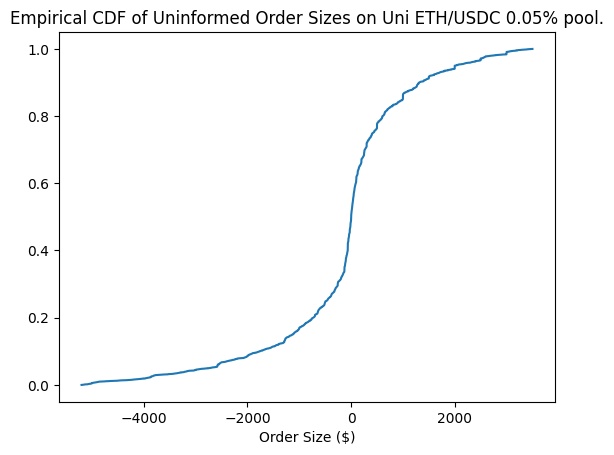

In [494]:
import matplotlib.pyplot as plt

k_ = 700 # omit first and last k_ values; initial way of getting rid of outliers
plt.plot(
    uninformed_swap_sizes_sorted_.iloc[k_:-k_],
    np.linspace(0, 1, len(uninformed_swap_sizes_)-2*k_, endpoint=False),
)
plt.title("Empirical CDF of Uninformed Order Sizes on Uni ETH/USDC 0.05% pool.");
plt.xlabel("Order Size ($)");

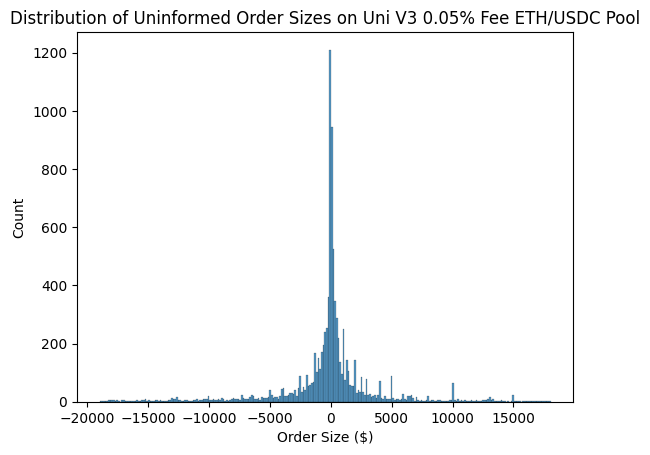

In [495]:
import seaborn as sns
sns.histplot(np.sort(uninformed_trade_sizes)[k_:-k_]);
plt.title("Distribution of Uninformed Order Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
plt.xlabel("Order Size ($)");

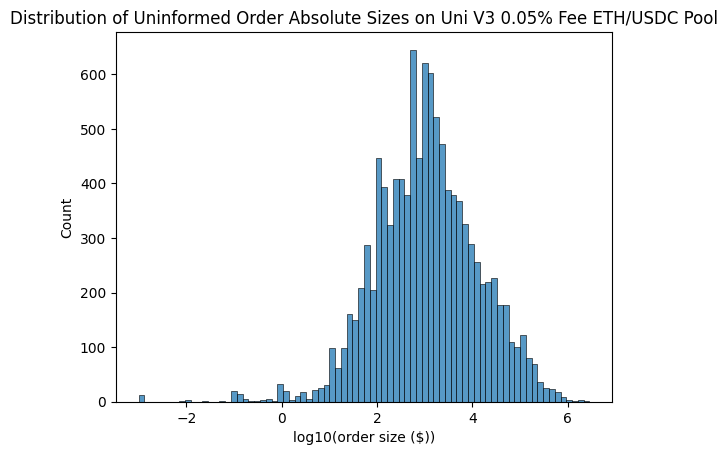

In [496]:
import seaborn as sns

sns.histplot(np.log10(np.abs(np.sort(uninformed_trade_sizes))));
plt.title("Distribution of Uninformed Order Absolute Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
plt.xlabel("log10(order size ($))");

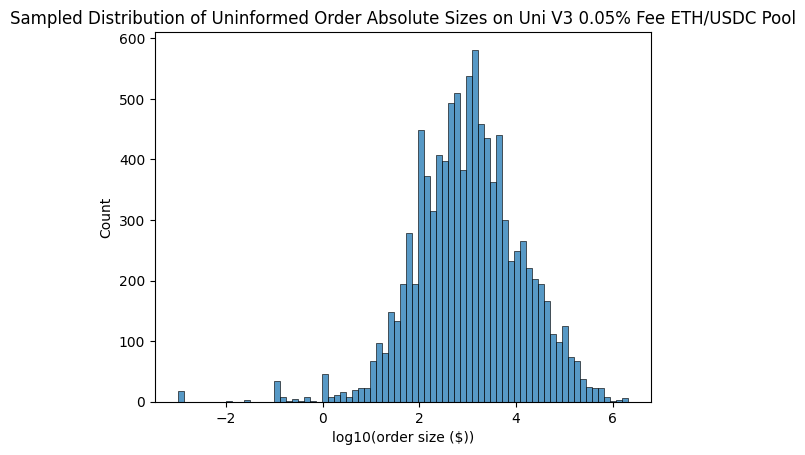

In [504]:
# sample from the ecdf
def sample_ecdf_single():
    r_ = np.random.uniform(0, 1)
    i_ = int(r_ * len(uninformed_sizes_sorted_))
    return uninformed_sizes_sorted_[i_]

def sample_ecdf(nsamples=10):
    return np.array([sample_ecdf_single() for _ in range(nsamples)])

def graph_sampled_abs_ecdf(nsamples=10_000):
    sns.histplot(np.log10(np.abs(sample_ecdf(nsamples))), bins=75)
    plt.title("Sampled Distribution of Uninformed Order Absolute Sizes on Uni V3 0.05% Fee ETH/USDC Pool");
    plt.xlabel("log10(order size ($))")
    plt.show();

graph_sampled_abs_ecdf()

## Takeaways
* The best, and easiest, way to determine an orderflow's information is by seeing if it went through a router.
* We can filter swaps by those that went through a router, than find the historical distribution of those swaps' sizes. This will help us to compute the value of uninformed orderflow for LPs, which depends on swap sizes.

## Open questions
* Should we consider orders informed if they were optimally routed? This is somewhat of a weird middle ground, where the traders are unsophisticated, yet the routes are high-information since they mean Uniswap had worse pricing than other places, yet they're also low information because Uniswap is the most liquid swapping route regardless of price, etc. We can look at the historical markout on these router orders to see if they're high information. I'm at least confident for now that Uniswap Router orders are low information, so we may just want to use those orders when calculating the distribution.
* How are we gonna handle JIT? JIT _actually happens_ somewhat frequently, and JIT precludes sandwiches, so it will affect our value to LPs. Nevertheless, that's pretty much out of scope for this report.